In [115]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
import math
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

In [116]:
import numpy as np
import pandas as pd

In [117]:
import tweepy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Vader sentiment analysis

#### Dictionary of scores and reviews

In [118]:
dbname = 'test'
collection_name1 = 'reviews'

path = "/Users/neerjadoshi/Downloads/"

input_file_name1 = path+"review_u200.json"

In [119]:
reviews200_df = sqlContext.read.json(input_file_name1)

In [120]:
reviews200_df.show(2)

+--------------------+--------------------+-----+--------------------+--------------------+
|         business_id|           review_id|stars|                text|             user_id|
+--------------------+--------------------+-----+--------------------+--------------------+
|5GcHJvxiTrIt23gB0...|zczyue447yED7newK...|    2|You certainly get...|P2E31XC7SP4v_3hXC...|
|5GcHJvxiTrIt23gB0...|9vGcS9Vze0XjYQgCi...|    2|The Chinese name ...|Wu0yySWcHQ5tZ_59H...|
+--------------------+--------------------+-----+--------------------+--------------------+
only showing top 2 rows



In [121]:
reviews = list(reviews200_df.select('text').rdd.map(lambda x: x[0]).collect())

In [122]:
stars = list(reviews200_df.select('stars').rdd.map(lambda x: x[0]).collect())

In [123]:
business = list(reviews200_df.select('business_id').rdd.map(lambda x: x[0]).collect())

In [124]:
review_star_dict_raw = dict(zip(reviews, stars))
# review_star_dict_raw

In [125]:
analyse = SentimentIntensityAnalyzer()

review_star_dict_pred = review_star_dict_raw.copy()

for i in reviews:
    review_star_dict_pred[i] = analyse.polarity_scores(i)['compound']

In [126]:
def derive_rating(reviews_dict):
    """
    take review_dict with scores in values in comment in key. 
    convert the score range of -1 to 1 to range of 1 to 5
    """   
    NewMax = 5
    NewMin = 1
    OldMax = 1
    OldMin = -1
    
    reviews_dict_updated = reviews_dict.copy()
    
    for t in reviews_dict.keys():
        score = reviews_dict_updated[t]
        OldValue = score
        NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
        NewValue_round = np.round(NewValue)
        reviews_dict_updated[t] = NewValue_round
    
    return reviews_dict_updated

In [127]:
review_star_dict_pred_updated = derive_rating(review_star_dict_pred)

In [128]:
# review_star_dict_pred_updated

Adding colors to sentiment for visualization purposes

In [ ]:
from colour import Color

def add_color(reviews_dict):
    """
    Given a list of tweets, one dictionary per tweet, add
    a "color" key to each tweets dictionary with a value
    containing a color graded from red to green. Pure red
    would be for -1.0 sentiment score and pure green would be for
    sentiment score 1.0.

    Use colour.Color to get 5 color values in the range
    from red to green. The index gives you the color increment
    from the 5 gradients.

    """
    color_dict = reviews_dict.copy()
    keys = reviews_dict.keys()

    colors = list(Color("red").range_to(Color("green"), 5))
    #colors2 = [colors.split() for c in colors]
    for t in keys:
        score = color_dict[t]
        color_dict[t] = str(colors[int(score-1)])

    return color_dict

In [ ]:
colored_pred_rating = add_color(review_star_dict_pred_updated)

In [ ]:
len(reviews)

In [ ]:
len(review_star_dict_pred_updated)

In [ ]:
len(review_star_dict_pred)

In [ ]:
list(Color("red").range_to(Color("green"), 5))

In [ ]:
key1 = colored_pred_rating.keys()[np.random.randint(1000)]
color1 = colored_pred_rating[key1]

In [ ]:
key1

In [ ]:
color1

In [ ]:
analyse.polarity_scores("My actual rating for the restaurant is 3.5 stars. The ambiance here is a step above other Chinese restaurants and the service is decently quick. The food was a mixed bag. The beef pancake roll was great and so was the beef noodle soup but make sure that you ask them to make it spicy because they don't do it by default. The mooshu pork was decent, nothing outstanding though. The same could be said for their bok choy. The one dish I would not get it again is their dan dan noodles. It did not have pork and it was not spicy enough. It was pretty much ramen noodles and peanut sauce mixed together.")['compound']

In [ ]:
score = review_star_dict_pred_updated["My actual rating for the restaurant is 3.5 stars. The ambiance here is a step above other Chinese restaurants and the service is decently quick. The food was a mixed bag. The beef pancake roll was great and so was the beef noodle soup but make sure that you ask them to make it spicy because they don't do it by default. The mooshu pork was decent, nothing outstanding though. The same could be said for their bok choy. The one dish I would not get it again is their dan dan noodles. It did not have pork and it was not spicy enough. It was pretty much ramen noodles and peanut sauce mixed together."]

In [ ]:
str(colors[int(score-1)])

In [ ]:
from IPython.display import Markdown, display
def printmd(color):
    display(Markdown('<font color = #50a000>  "My actual rating for the restaurant is 3.5 stars. The ambiance here is a step above other Chinese restaurants and the service is decently quick. The food was a mixed bag. The beef pancake roll was great and so was the beef noodle soup but make sure that you ask them to make it spicy because they do not do it by default. The mooshu pork was decent, nothing outstanding though. The same could be said for their bok choy. The one dish I would not get it again is their dan dan noodles. It did not have pork and it was not spicy enough. It was pretty much ramen noodles and peanut sauce mixed together." </font> '))
printmd(color1)

### Comparison of distributions of predicted vs original ratingsa

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#### original ratings

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x=review_star_dict_raw.values())
plt.show()

#### predicted ratings

In [ ]:
predictions = []

for t in review_star_dict_raw.keys():
    predictions.append(review_star_dict_pred_updated[t])
    
sns.set(style="darkgrid")
ax = sns.countplot(x=predictions)
plt.show()

#### both

In [ ]:
plt.figure(figsize=(10,5))
sns.set(style="darkgrid")
ax = sns.countplot(x=predictions, hue=review_star_dict_raw.values())
#ax.set_xlim(0,4)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Predicted rating by Vader Sentiment Analysis', fontsize=18)
plt.ylabel('Count',fontsize=18)
plt.show()

## Business wise aggregate

In [129]:
star_business = zip(stars, business)

review_star_dict_raw = dict(zip(reviews, star_business))
# review_star_dict_raw

In [130]:
analyse = SentimentIntensityAnalyzer()

review_star_dict_pred = review_star_dict_raw.copy()
for i in reviews:
    review_star_dict_pred[i] = (analyse.polarity_scores(i)['compound'], review_star_dict_pred[i][1])

# review_star_dict_pred

In [131]:
def derive_rating_aggregate(reviews_dict):
    """
    take review_dict with scores in values in comment in key. 
    convert the score range of -1 to 1 to range of 1 to 5
    """   
    NewMax = 5
    NewMin = 1
    OldMax = 1
    OldMin = -1
    
    reviews_dict_aggregate = reviews_dict.copy()
    
    for t in reviews_dict.keys():
        score = reviews_dict_aggregate[t][0]
        OldValue = score
        NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
        NewValue_round = np.round(NewValue)
        reviews_dict_aggregate[t] = (NewValue_round,reviews_dict_aggregate[t][1])
    
    return reviews_dict_aggregate

In [132]:
review_star_dict_pred_aggregate = derive_rating_aggregate(review_star_dict_pred)

# review_star_dict_pred_aggregate

In [133]:
agg_df = pd.DataFrame(review_star_dict_pred_aggregate.items(), columns=['Review', 'Tuple'])
agg_df[['predicted_stars', 'business_id']] = agg_df['Tuple'].apply(pd.Series)
agg_df = agg_df.drop(['Tuple'], axis=1)
agg_df.head()

,Review,predicted_stars,business_id
0,After experiencing what non-chain real Irish p...,4.0,CaETzvd1cA5mYaCReGAHjA
1,"Located in the strip that faces Lowe's, just a...",1.0,LHVfdNRDiQfRpDyHyzvI5A
2,Note to self: If the staff behind the counter ...,1.0,pa-C-Vsk9ntuXBGjTr0tBQ
3,I finally came in for a 2nd visit a year and a...,3.0,4U0Qfbqi8OtsMyujuSIRLQ
4,It seems like every woman who has ever shopped...,5.0,QJl-EAKJQjUZoBBQPKhCgg


In [134]:
new_df = agg_df.copy()
new_df = new_df.drop(['Review'], axis = 1)
new_df = new_df.groupby('business_id').mean()
# new_df

In [135]:
business_star_df = pd.DataFrame(star_business, columns=['Stars', 'business_id'])
business_star_df = business_star_df.groupby('business_id').mean()
# business_star_df

In [136]:
final_df = business_star_df.join(new_df, how = 'left')

In [137]:
def rmse(df):
    return np.sqrt(np.mean((df['predicted_stars']-df['Stars'])**2))
    

In [138]:
rmse(final_df)

1.2652921986094054

In [139]:
import matplotlib.pyplot as plt



In [140]:
final_df['diff'] = np.absolute(final_df['Stars']-final_df['predicted_stars'])
final_df.head()

,Stars,predicted_stars,diff
business_id,,,
--6MefnULPED_I942VcFNA,2.666667,4.666667,2.000000
--7zmmkVg-IMGaXbuVd0SQ,3.500000,4.750000,1.250000
--FBCX-N37CMYDfs790Bnw,4.000000,4.714286,0.714286
--KQsXc-clkO7oHRqGzSzg,2.000000,3.000000,1.000000
--SrzpvFLwP_YFwB_Cetow,3.750000,5.000000,1.250000


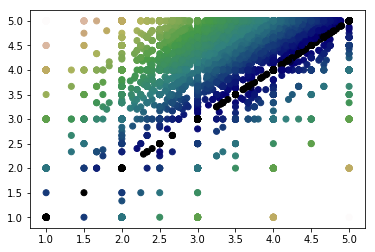

In [141]:
plt.scatter(final_df['Stars'], final_df['predicted_stars'], c=final_df['diff'], cmap=plt.cm.gist_earth)

plt.show()